In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../data/processed/spx500+commodity+emerging_2017-2024_notnull.csv")
df.head()

,date,symbol,open,high,low,close,volume,adj_close
0,2017-01-03,CORN,18.799999,19.059999,18.799999,18.930000,111000.0,18.930000
1,2017-01-03,CPER,16.840000,17.629999,16.000000,16.240000,11500.0,16.240000
2,2017-01-03,DBA,20.000000,20.100000,19.950001,19.959999,607600.0,18.502966
3,2017-01-03,DBB,14.860000,14.860000,14.750000,14.790000,429000.0,13.181738
4,2017-01-03,DBC,15.970000,15.980000,15.590000,15.650000,5935100.0,14.406545


In [3]:
# generate factors manually
df['hlc'] = (df['high'] - df['low']) / df['close']
df['coo'] = df['close']/df['open'] - 1
df['cll'] = df['close']/df['low'] - 1
df['chh'] = df['close']/df['high'] - 1

In [4]:
# generate factors according to GPT-4o
df['return'] = df.groupby('symbol')['adj_close'].pct_change()
df['MA5'] = df.groupby('symbol')['adj_close'].transform(lambda x: x.rolling(window=5).mean())
df['MA20'] = df.groupby('symbol')['adj_close'].transform(lambda x: x.rolling(window=20).mean())
df['MA50'] = df.groupby('symbol')['adj_close'].transform(lambda x: x.rolling(window=50).mean())
df['c-MA5'] = df['adj_close']/df['MA5'] - 1
df['c-MA20'] = df['adj_close']/df['MA20'] - 1
df['c-MA50'] = df['adj_close']/df['MA50'] - 1

df['EMA_12'] = df.groupby('symbol')['adj_close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
df['EMA_26'] = df.groupby('symbol')['adj_close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df.groupby('symbol')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
# generate MACD cross signal
df['MACD_Buy_Signal'] = ((df['MACD'] > df['Signal_Line']) & (df['MACD'].shift(1) <= df['Signal_Line'].shift(1))).astype(int)
df['MACD_Sell_Signal'] = ((df['MACD'] < df['Signal_Line']) & (df['MACD'].shift(1) >= df['Signal_Line'].shift(1))).astype(int)

# generate Bollinger Band breakthrough signal
df['BB_Middle'] = df.groupby('symbol')['adj_close'].transform(lambda x: x.rolling(window=20).mean())
df['BB_Upper'] = df['BB_Middle'] + 2 * df.groupby('symbol')['adj_close'].transform(lambda x: x.rolling(window=20).std())
df['BB_Lower'] = df['BB_Middle'] - 2 * df.groupby('symbol')['adj_close'].transform(lambda x: x.rolling(window=20).std())
df['BB_Buy_Signal'] = df['adj_close'] - df['BB_Lower']  # <
df['BB_Sell_Signal'] = df['adj_close'] - df['BB_Upper']  # >

# calculate the relative strength index (RSI)
def RSI(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = df.groupby('symbol')['adj_close'].transform(lambda x: RSI(x, 14))

C:\Users\zhang\AppData\Local\Temp\ipykernel_17760\1738863989.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['return'] = df.groupby('symbol')['adj_close'].pct_change()


In [5]:
# df.to_csv("../data/processed/factors_one.csv", index=False)

In [6]:
df['return'].describe()

count    948141.000000
mean          0.000659
std           0.021073
min          -0.538647
25%          -0.008350
50%           0.000804
75%           0.009825
max           0.745932
Name: return, dtype: float64

In [7]:
df.tail()

,date,symbol,open,high,low,close,volume,adj_close,hlc,coo,...,MACD,Signal_Line,MACD_Buy_Signal,MACD_Sell_Signal,BB_Middle,BB_Upper,BB_Lower,BB_Buy_Signal,BB_Sell_Signal,RSI_14
950584,2024-05-14,XYL,141.259995,142.720001,140.929993,142.070007,949800.0,141.699249,0.012599,0.005734,...,3.744759,2.951400,1,0,134.220313,145.657155,122.783470,18.915779,-3.957906,80.383855
950585,2024-05-14,YUM,136.520004,138.449997,136.190002,137.490005,2180300.0,136.817657,0.016438,0.007105,...,-0.299998,-0.103838,0,1,137.632151,142.710958,132.553344,4.264314,-5.893301,37.699302
950586,2024-05-14,ZBH,119.949997,120.510002,118.330002,119.970001,1348700.0,119.970001,0.018171,0.000167,...,-1.118492,-1.302829,1,0,120.472499,122.426410,118.518589,1.451412,-2.456409,46.250017
950587,2024-05-14,ZBRA,318.390015,322.779999,317.850006,320.980011,216300.0,320.980011,0.015359,0.008135,...,8.548717,6.990762,0,0,300.075500,338.384463,261.766538,59.213473,-17.404452,81.480921
950588,2024-05-14,ZTS,169.809998,170.199997,168.630005,168.869995,2050100.0,168.869995,0.009297,-0.005536,...,1.606430,-0.120992,0,0,159.694400,176.065517,143.323283,25.546713,-7.195522,77.874207


In [8]:
df.shape

(950589, 31)

In [5]:
# 2. for clustering
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

import seaborn as sns
import matplotlib.pyplot as plt

from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction.settings import EfficientFCParameters

In [6]:
df_2017 = df[(df['date'] >= '2017-01-01') & (df['date'] <= '2017-12-30')].copy()
df_2017 = df_2017.dropna(axis='index')
df_2017

,date,symbol,open,high,low,close,volume,adj_close,hlc,coo,...,MACD,Signal_Line,MACD_Buy_Signal,MACD_Sell_Signal,BB_Middle,BB_Upper,BB_Lower,BB_Buy_Signal,BB_Sell_Signal,RSI_14
1421,2017-03-15,CORN,19.010000,19.010000,18.889999,18.950001,32300.0,18.950001,0.006332,-0.003156,...,-0.134965,-0.042025,0,0,19.441000,20.129948,18.752052,0.197948,-1.179947,39.449564
1422,2017-03-15,CPER,17.360001,17.420000,17.320000,17.420000,5100.0,17.420000,0.005741,0.003456,...,-0.076771,-0.032774,0,0,17.469500,18.177097,16.761903,0.658097,-0.757097,52.657020
1423,2017-03-15,DBA,20.000000,20.110001,20.000000,20.080000,890600.0,18.614208,0.005478,0.004000,...,-0.117774,-0.092416,0,0,18.807025,19.260987,18.353063,0.261145,-0.646779,36.301243
1424,2017-03-15,DBB,16.170000,16.340000,16.170000,16.290001,340300.0,14.518629,0.010436,0.007421,...,-0.015831,0.017916,0,0,14.487880,14.959933,14.015827,0.502802,-0.441304,54.634161
1425,2017-03-15,DBC,14.920000,14.990000,14.870000,14.960000,3442700.0,13.771368,0.008021,0.002681,...,-0.211212,-0.135849,0,0,14.252354,14.917508,13.587200,0.184168,-1.146140,23.448209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175216,2017-12-29,XYL,68.529999,68.800003,67.919998,68.199997,1046700.0,63.057022,0.012903,-0.004815,...,0.259982,0.290593,0,1,62.772249,63.735682,61.808815,1.248207,-0.678660,50.113298
175217,2017-12-29,YUM,82.639999,82.709999,81.589996,81.610001,1347600.0,72.585533,0.013724,-0.012464,...,0.500547,0.731247,0,0,73.477627,74.415278,72.539976,0.045557,-1.829745,35.630091
175218,2017-12-29,ZBH,118.203880,118.398056,117.106796,117.155342,1054308.0,111.635948,0.011022,-0.008871,...,1.626387,1.084024,1,0,107.909759,114.042029,101.777488,9.858460,-2.406081,73.631006
175219,2017-12-29,ZBRA,104.330002,104.940002,103.279999,103.800003,159500.0,103.800003,0.015992,-0.005080,...,-1.061514,-1.011452,0,1,105.884000,110.116732,101.651268,2.148735,-6.316729,35.140981


In [7]:
# clustering by correlation 
pivot_df = df_2017[['date','symbol','adj_close']].pivot(index='date', columns='symbol', values='adj_close')
pivot_df = pivot_df.fillna(method='ffill').fillna(method='bfill')
pivot_df

C:\Users\zhang\AppData\Local\Temp\ipykernel_17760\1344812115.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot_df = pivot_df.fillna(method='ffill').fillna(method='bfill')


symbol,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2017-03-15,51.174427,40.763428,32.735188,48.500126,39.862858,31.879999,111.196579,122.110001,72.884857,36.713184,...,117.098801,25.242058,96.308121,35.768951,58.250195,44.491081,56.135452,109.817154,90.889999,51.621510
2017-03-16,50.181206,40.802174,32.788784,48.026409,39.563801,31.833332,110.572884,122.349998,72.195374,36.582676,...,116.495171,25.137743,97.613686,35.387306,58.299942,44.665161,56.056381,109.596893,91.309998,51.764164
2017-03-17,50.427151,40.405098,32.625656,47.873371,39.748505,31.866667,111.570793,127.010002,72.666679,36.476646,...,117.089798,24.735430,101.309700,35.606548,58.250195,45.040813,56.100304,111.671150,90.750000,51.355225
2017-03-20,50.275803,40.385719,32.968246,47.953529,39.563801,31.733334,110.831253,126.309998,72.352493,36.582676,...,117.297020,24.869535,102.642853,35.395416,58.250195,44.738464,56.275978,111.652794,90.070000,51.621510
2017-03-21,49.812294,39.146061,32.590679,47.625587,39.405468,31.203333,111.054024,125.070000,71.392426,36.664246,...,116.396057,24.646027,102.743988,36.020676,58.129459,44.032986,55.977341,111.037895,86.150002,50.775101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,64.140121,51.257690,41.264294,73.443825,50.907757,29.903334,139.880051,175.000000,78.825294,33.556290,...,138.238373,26.765181,155.979813,39.771881,61.359215,62.483780,73.288185,110.905113,105.150002,68.821808
2017-12-26,64.044876,51.511108,40.217422,73.099831,50.970352,30.090000,139.061966,174.440002,78.630104,33.614738,...,138.356812,26.857109,156.788757,39.425674,61.366520,62.409813,73.101433,110.757393,104.790001,69.156425
2017-12-27,64.092514,51.072506,40.224491,73.354088,51.390636,30.160000,139.361969,175.360001,79.047073,33.598038,...,138.147263,26.887749,158.267212,39.699764,61.308064,63.084774,73.288185,110.923576,104.949997,69.261581


In [14]:
baseline_row = pivot_df.loc['2017-03-15']

# broadcasting with numpy arrays
normalized_array = pivot_df.values / baseline_row.values
normalized_df = pd.DataFrame(normalized_array, index=pivot_df.index, columns=pivot_df.columns)
normalized_df

symbol,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2017-03-15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2017-03-16,0.980591,1.000951,1.001637,0.990233,0.992498,0.998536,0.994391,1.001965,0.990540,0.996445,...,0.994845,0.995867,1.013556,0.989330,1.000854,1.003913,0.998591,0.997994,1.004621,1.002763
2017-03-17,0.985397,0.991210,0.996654,0.987077,0.997131,0.999582,1.003365,1.040128,0.997007,0.993557,...,0.999923,0.979929,1.051933,0.995460,1.000000,1.012356,0.999374,1.016883,0.998460,0.994842
2017-03-20,0.982440,0.990734,1.007120,0.988730,0.992498,0.995399,0.996715,1.034395,0.992696,0.996445,...,1.001693,0.985242,1.065776,0.989557,1.000000,1.005560,1.002503,1.016715,0.990978,1.000000
2017-03-21,0.973383,0.960323,0.995586,0.981968,0.988526,0.978775,0.998718,1.024240,0.979523,0.998667,...,0.993999,0.976387,1.066826,1.007038,0.997927,0.989704,0.997183,1.011116,0.947849,0.983604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,1.253363,1.257443,1.260549,1.514302,1.277072,0.937997,1.257953,1.433134,1.081504,0.914012,...,1.180528,1.060341,1.619591,1.111911,1.053374,1.404411,1.305560,1.009907,1.156893,1.333200
2017-12-26,1.251502,1.263660,1.228569,1.507209,1.278643,0.943852,1.250596,1.428548,1.078826,0.915604,...,1.181539,1.063983,1.627991,1.102232,1.053499,1.402749,1.302233,1.008562,1.152932,1.339682
2017-12-27,1.252432,1.252900,1.228785,1.512451,1.289186,0.946048,1.253294,1.436082,1.084547,0.915149,...,1.179750,1.065196,1.643342,1.109895,1.052495,1.417920,1.305560,1.010075,1.154692,1.341719


In [9]:
corr_matrix = pivot_df.corr()
distance_matrix = 1 - corr_matrix
distance_matrix

symbol,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
symbol,,,,,,,,,,,,,,,,,,,,,
A,0.000000,0.446875,0.146105,0.074542,0.047566,0.838622,0.090096,0.085170,0.196256,1.524590,...,0.055025,0.401626,0.074022,0.083595,0.580079,0.040363,0.091098,1.369953,0.136034,0.086782
AAL,0.446875,0.000000,0.651813,0.527038,0.435333,0.911272,0.512971,0.548134,0.676838,1.480305,...,0.385010,0.710611,0.439014,0.579434,0.659262,0.509354,0.354585,0.679736,0.385539,0.358703
AAPL,0.146105,0.651813,0.000000,0.177715,0.188323,1.104502,0.106042,0.078081,0.272444,1.602238,...,0.215156,0.409670,0.132879,0.119407,0.576267,0.116870,0.133622,1.595801,0.332258,0.133201
ABBV,0.074542,0.527038,0.177715,0.000000,0.036998,0.961220,0.044255,0.099231,0.125578,1.389989,...,0.151423,0.213727,0.076350,0.173839,0.364862,0.051140,0.182700,1.376793,0.269150,0.129670
ABT,0.047566,0.435333,0.188323,0.036998,0.000000,0.898414,0.059884,0.096524,0.169440,1.451496,...,0.100462,0.311851,0.077766,0.135597,0.498953,0.034212,0.125754,1.311330,0.229907,0.120447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,0.040363,0.509354,0.116870,0.051140,0.034212,0.920769,0.056305,0.083888,0.211106,1.455036,...,0.106228,0.362819,0.072015,0.089765,0.558612,0.000000,0.098332,1.473713,0.229301,0.115628
YUM,0.091098,0.354585,0.133622,0.182700,0.125754,1.080319,0.126997,0.125634,0.386021,1.680168,...,0.119186,0.517776,0.077103,0.089673,0.654951,0.098332,0.000000,1.326005,0.218271,0.043768
ZBH,1.369953,0.679736,1.595801,1.376793,1.311330,1.010490,1.410261,1.420271,1.343769,0.886578,...,1.309834,1.182877,1.317370,1.506739,1.010377,1.473713,1.326005,0.000000,1.225829,1.276575


In [10]:
# hierarchical clustering;       https://cloud.tencent.com/developer/article/2323005
clustering = AgglomerativeClustering(
    n_clusters=5, metric='precomputed', linkage='average'
)
clustering.fit(distance_matrix)

cluster_labels = clustering.labels_

In [13]:
symbols = corr_matrix.columns
cluster_df = pd.DataFrame({'symbol': symbols, 'cluster': cluster_labels})

for i in range(5):
    cluster_symbols = cluster_df[cluster_df['cluster'] == i]['symbol'].tolist()
    print(f"Cluster {i} symbols: {cluster_symbols}")

Cluster 0 symbols: ['ACGL', 'ADM', 'EQT', 'GEN', 'KIM', 'O', 'OKE', 'PPLT', 'SLB', 'SLV', 'TRGP', 'WMB']
Cluster 1 symbols: ['AKAM', 'AZO', 'BBWI', 'BXP', 'CL', 'COST', 'DFS', 'DVN', 'EVRG', 'FAST', 'FFIV', 'FRT', 'FTNT', 'GPC', 'GWW', 'HAL', 'HES', 'HPE', 'HRL', 'HSY', 'HWM', 'IBM', 'LOW', 'MKC', 'MOS', 'MRO', 'NDSN', 'NKE', 'NUE', 'ORLY', 'POOL', 'PSA', 'QCOM', 'REG', 'ROST', 'SNA', 'SO', 'SPG', 'STX', 'SYF', 'SYY', 'TJX', 'TSCO', 'VTRS', 'WRB']
Cluster 2 symbols: ['AES', 'AIG', 'AIZ', 'AMD', 'APA', 'AVB', 'AXON', 'BG', 'BKNG', 'BKR', 'CAG', 'CAH', 'CHD', 'CMCSA', 'CMG', 'COR', 'CORN', 'CPB', 'CVS', 'DBA', 'DGX', 'DIS', 'DOC', 'DPZ', 'DRI', 'DVA', 'DXCM', 'EFX', 'EG', 'EWW', 'EXPE', 'GE', 'GIS', 'HAS', 'HCA', 'HOLX', 'HSIC', 'IDXX', 'INCY', 'IPG', 'JBL', 'JCI', 'JNPR', 'K', 'KDP', 'KHC', 'KMB', 'KMI', 'KR', 'MCK', 'MDLZ', 'MDT', 'MKTX', 'MLM', 'MO', 'MRK', 'OMC', 'PARA', 'PCG', 'PM', 'PPL', 'REGN', 'SBUX', 'SJM', 'SMCI', 'T', 'TAP', 'TMUS', 'TPR', 'UAL', 'UHS', 'ULTA', 'UNG', 'VMC', 

In [11]:
# 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(normalized_df.T)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame({
    'PCA1': pca_result[:, 0],
    'PCA2': pca_result[:, 1],
    'cluster': cluster_labels,
    'symbol': symbols
})


NameError: name 'symbols' is not defined

In [21]:
pca_df

,PCA1,PCA2,cluster,symbol
0,8.443102,-1.964142,4,A
1,9.692993,4.760218,4,AAL
2,5.745894,1.853974,4,AAPL
3,11.730361,-9.246254,4,ABBV
4,4.282734,-4.683783,4,ABT
...,...,...,...,...
504,15.800725,-1.336651,4,XYL
505,11.468097,1.578026,4,YUM
506,-5.245494,6.052494,2,ZBH
507,7.649016,1.383200,4,ZBRA


Cluster 0 symbols: ['ACGL', 'ADM', 'EQT', 'GEN', 'KIM', 'O', 'OKE', 'PPLT', 'SLB', 'SLV', 'TRGP', 'WMB']
Cluster 1 symbols: ['AKAM', 'AZO', 'BBWI', 'BXP', 'CL', 'COST', 'DFS', 'DVN', 'EVRG', 'FAST', 'FFIV', 'FRT', 'FTNT', 'GPC', 'GWW', 'HAL', 'HES', 'HPE', 'HRL', 'HSY', 'HWM', 'IBM', 'LOW', 'MKC', 'MOS', 'MRO', 'NDSN', 'NKE', 'NUE', 'ORLY', 'POOL', 'PSA', 'QCOM', 'REG', 'ROST', 'SNA', 'SO', 'SPG', 'STX', 'SYF', 'SYY', 'TJX', 'TSCO', 'VTRS', 'WRB']
Cluster 2 symbols: ['AES', 'AIG', 'AIZ', 'AMD', 'APA', 'AVB', 'AXON', 'BG', 'BKNG', 'BKR', 'CAG', 'CAH', 'CHD', 'CMCSA', 'CMG', 'COR', 'CORN', 'CPB', 'CVS', 'DBA', 'DGX', 'DIS', 'DOC', 'DPZ', 'DRI', 'DVA', 'DXCM', 'EFX', 'EG', 'EWW', 'EXPE', 'GE', 'GIS', 'HAS', 'HCA', 'HOLX', 'HSIC', 'IDXX', 'INCY', 'IPG', 'JBL', 'JCI', 'JNPR', 'K', 'KDP', 'KHC', 'KMB', 'KMI', 'KR', 'MCK', 'MDLZ', 'MDT', 'MKTX', 'MLM', 'MO', 'MRK', 'OMC', 'PARA', 'PCG', 'PM', 'PPL', 'REGN', 'SBUX', 'SJM', 'SMCI', 'T', 'TAP', 'TMUS', 'TPR', 'UAL', 'UHS', 'ULTA', 'UNG', 'VMC', 

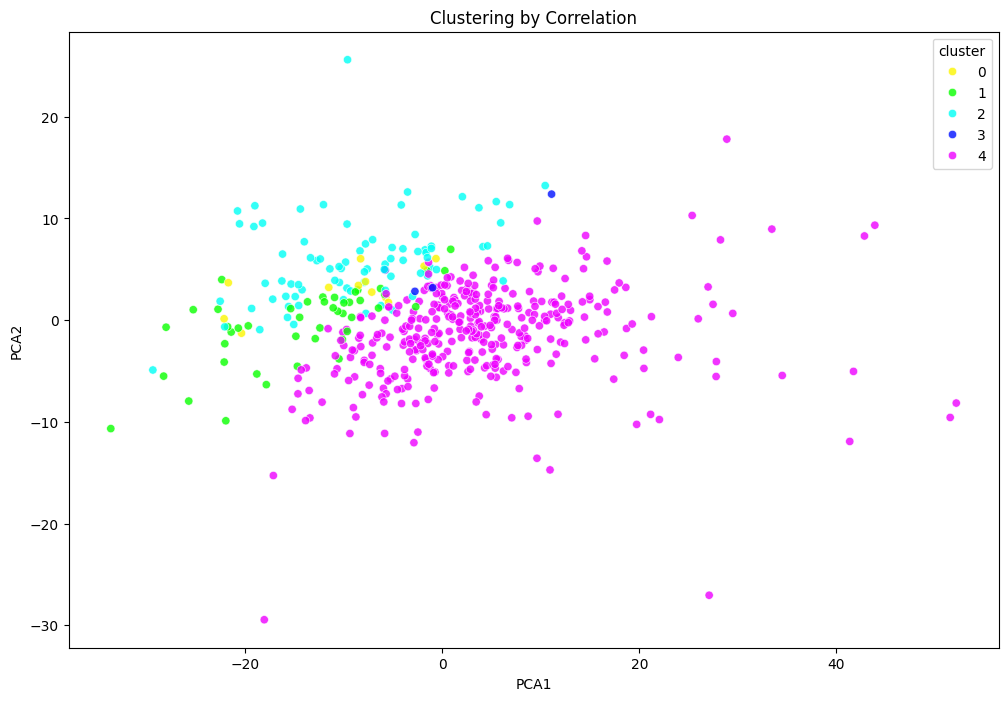

In [15]:
pca_df = pd.DataFrame({
    'PCA1': pca_result[:, 0],
    'PCA2': pca_result[:, 1],
    'cluster': cluster_labels,
    'symbol': symbols
})

for i in range(0, 5):
    cluster_symbols = pca_df[pca_df['cluster'] == i]['symbol'].tolist()
    print(f"Cluster {i} symbols: {cluster_symbols}")

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='cluster',
    palette=sns.color_palette('hsv', 5),
    data=pca_df,
    legend="full",
    alpha=0.8
)
# for i in range(pca_df.shape[0]):
#     plt.text(pca_df['PCA1'][i], pca_df['PCA2'][i], pca_df['symbol'][i], fontsize=9)
plt.title('Clustering by Correlation')
plt.show()

In [28]:
# cluster_df.to_csv("../data/processed/cluster_correlation.csv", index=False)

In [29]:
# clustering according to 2017 time series: using tsfreshing package
features_df = df_2017[['date', 'symbol', 'adj_close', 'volume', 'return']]
# Extracting features
extracted_features = extract_features(
    features_df,
    column_id='symbol',
    column_sort='date',
    default_fc_parameters=EfficientFCParameters(),
    n_jobs=4
)

# Handling NaN values in extracted features
extracted_features.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN
extracted_features.dropna(axis=1, inplace=True)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(extracted_features)

kmeans = KMeans(n_clusters=5, random_state=42)  # supposed divided into 5 groups
extracted_features['cluster'] = kmeans.fit_predict(scaled_features)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [01:03<00:00,  3.19s/it]


In [30]:
extracted_features

,adj_close__variance_larger_than_standard_deviation,adj_close__has_duplicate_max,adj_close__has_duplicate_min,adj_close__has_duplicate,adj_close__sum_values,adj_close__abs_energy,adj_close__mean_abs_change,adj_close__mean_change,adj_close__mean_second_derivative_central,adj_close__median,...,return__fourier_entropy__bins_5,return__fourier_entropy__bins_10,return__fourier_entropy__bins_100,return__permutation_entropy__dimension_3__tau_1,return__permutation_entropy__dimension_4__tau_1,return__permutation_entropy__dimension_5__tau_1,return__permutation_entropy__dimension_6__tau_1,return__permutation_entropy__dimension_7__tau_1,return__mean_n_absolute_max__number_of_maxima_7,cluster
A,1.0,0.0,0.0,1.0,11834.149796,6.983700e+05,0.409911,0.063408,0.001693,58.054104,...,0.710952,1.299733,3.187522,1.789858,3.150992,4.471902,5.117765,5.249823,0.033547,3
AAL,1.0,0.0,0.0,1.0,9382.867500,4.380333e+05,0.594820,0.049495,-0.001145,46.611530,...,1.117367,1.771597,3.620829,1.786539,3.132723,4.470626,5.090548,5.242750,0.051618,0
AAPL,1.0,0.0,0.0,1.0,7377.490318,2.707730e+05,0.301886,0.035653,-0.001224,36.281900,...,1.074483,1.720209,3.550918,1.783468,3.125869,4.424121,5.104622,5.256896,0.034726,4
ABBV,1.0,0.0,0.0,1.0,11732.371719,6.993388e+05,0.475634,0.118517,-0.000835,53.545334,...,1.013840,1.654122,3.597942,1.787171,3.155879,4.510828,5.146844,5.263969,0.039811,3
ABT,1.0,0.0,0.0,1.0,8966.223694,4.015359e+05,0.299136,0.055573,-0.000124,43.865843,...,1.005643,1.647314,3.573915,1.785796,3.119676,4.418396,5.092273,5.256896,0.023304,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,1.0,0.0,0.0,1.0,10926.041645,5.986932e+05,0.377176,0.092368,-0.000551,54.523497,...,1.261637,1.900466,3.692401,1.782861,3.123504,4.449712,5.062400,5.228604,0.031956,3
YUM,1.0,0.0,0.0,1.0,13218.341499,8.700620e+05,0.382487,0.081841,-0.002159,66.092201,...,1.056372,1.726646,3.629575,1.787525,3.146367,4.471992,5.104622,5.242750,0.029750,3
ZBH,1.0,0.0,0.0,1.0,22198.787971,2.444283e+06,0.908505,0.009049,-0.001947,109.906319,...,0.883556,1.535303,3.466511,1.781869,3.143900,4.504616,5.128389,5.256896,0.040601,3
ZBRA,1.0,0.0,0.0,1.0,20708.389999,2.132184e+06,1.113085,0.064229,-0.002250,103.740002,...,1.193769,1.822345,3.724537,1.784374,3.141552,4.421266,5.048326,5.228604,0.052909,0


In [31]:
# extracted_features.to_csv("../data/processed/cluster_tsfresh.csv")

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [33]:
extracted_features = pd.read_csv("../data/processed/cluster_tsfresh.csv").rename(columns={'Unnamed: 0': 'symbol'}).set_index('symbol')
# extracted_features.reset_index(inplace=True)
extracted_features

,adj_close__variance_larger_than_standard_deviation,adj_close__has_duplicate_max,adj_close__has_duplicate_min,adj_close__has_duplicate,adj_close__sum_values,adj_close__abs_energy,adj_close__mean_abs_change,adj_close__mean_change,adj_close__mean_second_derivative_central,adj_close__median,...,return__fourier_entropy__bins_5,return__fourier_entropy__bins_10,return__fourier_entropy__bins_100,return__permutation_entropy__dimension_3__tau_1,return__permutation_entropy__dimension_4__tau_1,return__permutation_entropy__dimension_5__tau_1,return__permutation_entropy__dimension_6__tau_1,return__permutation_entropy__dimension_7__tau_1,return__mean_n_absolute_max__number_of_maxima_7,cluster
symbol,,,,,,,,,,,,,,,,,,,,,
A,1.0,0.0,0.0,1.0,11834.149796,6.983700e+05,0.409911,0.063408,0.001693,58.054104,...,0.710952,1.299733,3.187522,1.789858,3.150992,4.471902,5.117765,5.249823,0.033547,3
AAL,1.0,0.0,0.0,1.0,9382.867500,4.380333e+05,0.594820,0.049495,-0.001145,46.611530,...,1.117367,1.771597,3.620829,1.786539,3.132723,4.470626,5.090548,5.242750,0.051618,0
AAPL,1.0,0.0,0.0,1.0,7377.490318,2.707730e+05,0.301886,0.035653,-0.001224,36.281900,...,1.074483,1.720209,3.550918,1.783468,3.125869,4.424121,5.104622,5.256896,0.034726,4
ABBV,1.0,0.0,0.0,1.0,11732.371719,6.993388e+05,0.475634,0.118517,-0.000835,53.545334,...,1.013840,1.654122,3.597942,1.787171,3.155879,4.510828,5.146844,5.263969,0.039811,3
ABT,1.0,0.0,0.0,1.0,8966.223694,4.015359e+05,0.299136,0.055573,-0.000124,43.865843,...,1.005643,1.647314,3.573915,1.785796,3.119676,4.418396,5.092273,5.256896,0.023304,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,1.0,0.0,0.0,1.0,10926.041645,5.986932e+05,0.377176,0.092368,-0.000551,54.523497,...,1.261637,1.900466,3.692401,1.782861,3.123504,4.449712,5.062400,5.228604,0.031956,3
YUM,1.0,0.0,0.0,1.0,13218.341499,8.700620e+05,0.382487,0.081841,-0.002159,66.092201,...,1.056372,1.726646,3.629575,1.787525,3.146367,4.471992,5.104622,5.242750,0.029750,3
ZBH,1.0,0.0,0.0,1.0,22198.787971,2.444283e+06,0.908505,0.009049,-0.001947,109.906319,...,0.883556,1.535303,3.466511,1.781869,3.143900,4.504616,5.128389,5.256896,0.040601,3


In [35]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(extracted_features)

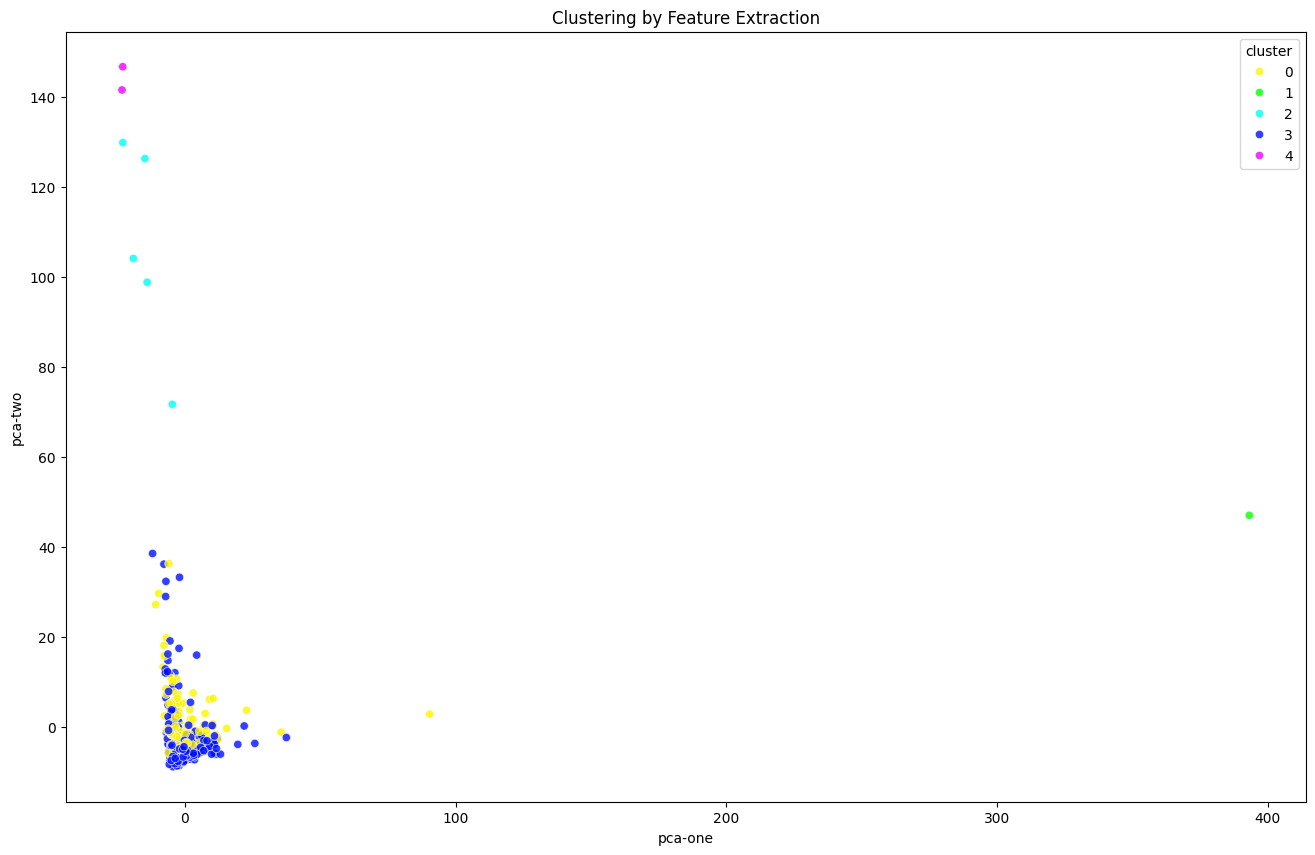

In [36]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

plt_features = extracted_features.copy()
plt_features['pca-one'] = pca_result[:, 0]
plt_features['pca-two'] = pca_result[:, 1]

# Visualization
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="cluster",
    palette=sns.color_palette("hsv", 5),
    data=plt_features,
    legend="full",
    alpha=0.8
)
plt.title('Clustering by Feature Extraction')
plt.show()

In [ ]:
# Using DBSCAN to ensure minimum number of points in each cluster
dbscan = DBSCAN(eps=0.5, min_samples=5)
extracted_features['dbscan_cluster'] = dbscan.fit_predict(scaled_features)

In [ ]:
# clustering according to 2017 time series: using correlation